## Data description
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

In [73]:
# import necessary packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime

In [74]:
os.chdir('C:\Springboard\Github\Ch26_2_Take_home')

In [75]:
# import the JSON file first
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


This looks good. Let's look at the data a little more closeley

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [77]:
# let's convert the dates to datetime objects
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], infer_datetime_format=True)
df['signup_date'] = pd.to_datetime(df['signup_date'], infer_datetime_format=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

That is much better. Let's add a booleen column based on whether each user was active in the last month

In [78]:
# lets see the range of the signup date
df['signup_date'].describe()

count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

This looks good. All of the users signed up in January 2014.

In [79]:
# most recent date
recent_date = df['last_trip_date'].max()
recent_date

Timestamp('2014-07-01 00:00:00')

In [80]:
# I was going to do something to automatically pull the correct date, but I will just do this manually
last_month = datetime.date(2014, 6, 1)
type(last_month)

datetime.date

In [81]:
# creates dependent variable in the DateFrame - are they an active user or not 
df['active'] = (df['last_trip_date'] > pd.to_datetime(last_month))
# let's see if that worked
df['active'].value_counts()

False    31690
True     18310
Name: active, dtype: int64

This is good, but for logistic regression and further analysis, it's easier if they are 1 and 0

## 1. What fraction of the observed users were retained?

In [82]:
df['active'].replace(to_replace=[True, False], value=[1,0], inplace=True)

In [83]:
# let's find out the exact fraction of users that were active in the last month
per_active = (df[df['active'] == 1]['active'].sum()*100)/df.shape[0]
per_active

36.62

## 36.62% of users acquired in January 2014 were active in June 2014

Now, it's time to build a model to see if we could predict whether a user will be retained based on data from their signup month (January 2014). Before we do that, we'll have to clean up some of the data - fill in missing values or drop them from the dataset.

In [84]:
# look at the phone column values
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [85]:
# fill in the missing phone data (there are other missing OS's like Microsoft and Blackberry?)
df['phone'].fillna(value='other', inplace=True)

In [86]:
# there are only 201 missing ratings by the driver in the dataset. These would all be outliers, so we will drop them
df = df[~df['avg_rating_by_driver'].isna()]

#### that takes care of filling phone and average rating by driver; let's see what's left

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49799 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49799 non-null  object        
 1   trips_in_first_30_days  49799 non-null  int64         
 2   signup_date             49799 non-null  datetime64[ns]
 3   avg_rating_of_driver    41744 non-null  float64       
 4   avg_surge               49799 non-null  float64       
 5   last_trip_date          49799 non-null  datetime64[ns]
 6   phone                   49799 non-null  object        
 7   surge_pct               49799 non-null  float64       
 8   ultimate_black_user     49799 non-null  bool          
 9   weekday_pct             49799 non-null  float64       
 10  avg_dist                49799 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  active                  49799 non-null  int64 

We need to address the missing values in average rating OF driver; these are significant, as those missing values are around 19% of the users. Let's create another DF as missing driver rating and see if those users have a different retention rate

In [88]:
no_rating = df[df['avg_rating_of_driver'].isna()]
per_act_nr = (no_rating[no_rating['active'] == 1]['active'].sum()*100)/no_rating.shape[0]
per_act_nr

19.217877094972067

That's a much lower retention rate than the average user. Users that don't rate drivers must be less engaged in the app. <br>
How do I incorporate this into the model while still filling in values? I will ponder that thought for a second while I look at the Predictive Power Score on the remaining values in the data frame.

In [89]:
dff = df[~df['avg_rating_of_driver'].isna()]

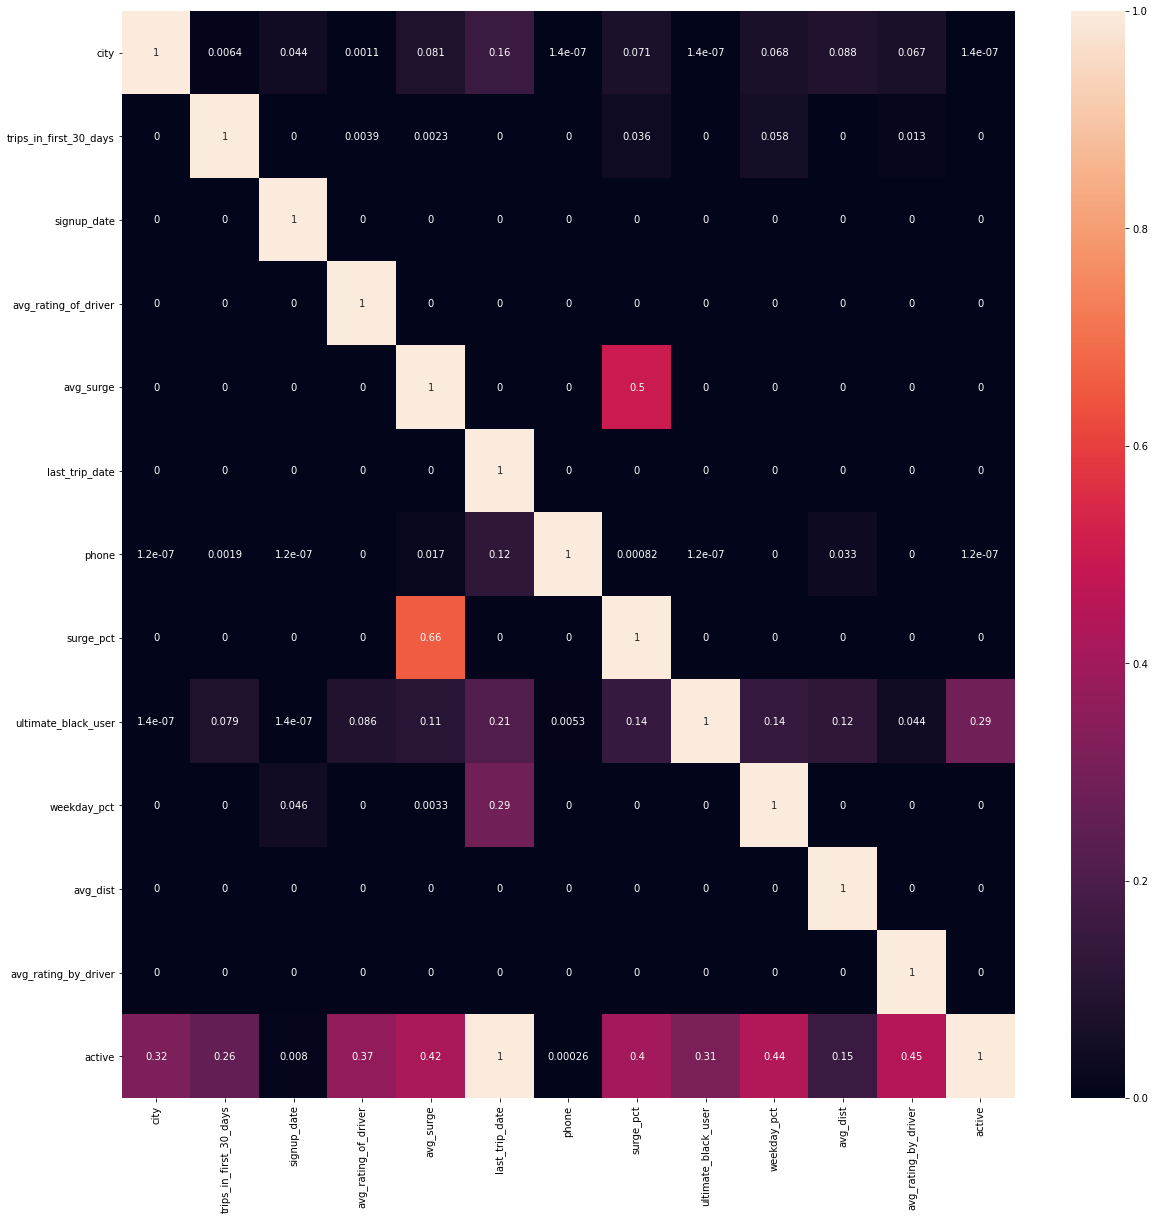

In [90]:
import ppscore as pps
import seaborn as sns
dff_pps = pps.matrix(dff)
fig, ax = plt.subplots(figsize=(20,20))
_ = sns.heatmap(dff_pps, annot=True, ax=ax)

average rating of driver had a predictive power score of 0.37; let's see if the fact that somebody left a driver rating is has a better predictive power score <br>
We should also be able to drop: <br>
- signup date
- phone
- last trip date (since it would not be known in January) <br>
we'll drop those after looking at rating vs not rating at all

In [91]:
# create feature column whether they left a rating or not
df['rt'] = ~df['avg_rating_of_driver'].isna()
df['rt'].replace(to_replace=[True, False], value=[1,0], inplace=True)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49799 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49799 non-null  object        
 1   trips_in_first_30_days  49799 non-null  int64         
 2   signup_date             49799 non-null  datetime64[ns]
 3   avg_rating_of_driver    41744 non-null  float64       
 4   avg_surge               49799 non-null  float64       
 5   last_trip_date          49799 non-null  datetime64[ns]
 6   phone                   49799 non-null  object        
 7   surge_pct               49799 non-null  float64       
 8   ultimate_black_user     49799 non-null  bool          
 9   weekday_pct             49799 non-null  float64       
 10  avg_dist                49799 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  active                  49799 non-null  int64 

In [93]:
# drop the rating column and run the PPS again with the no rating column in and see if that has a stronger PPS score
dfr = df.drop("avg_rating_of_driver", axis=1)

In [94]:
dfr.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_surge',
       'last_trip_date', 'phone', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'active', 'rt'],
      dtype='object')

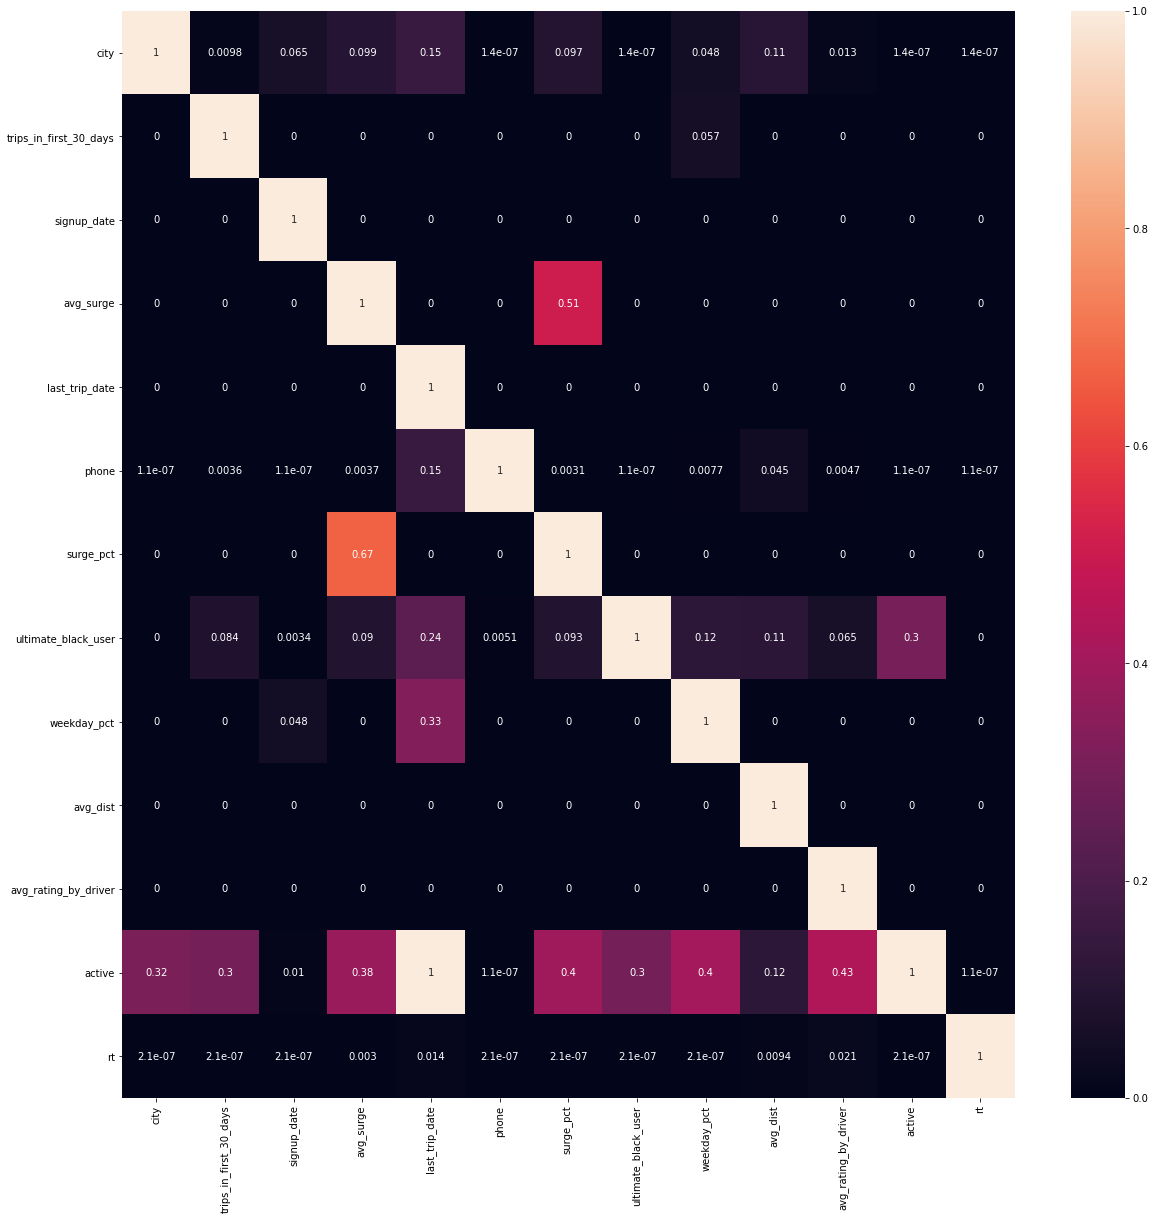

In [95]:
dfr_pps = pps.matrix(dfr)
fig, ax = plt.subplots(figsize=(20,20))
_ = sns.heatmap(dfr_pps, annot=True, ax=ax)

Based on PPS, it looks like the rating is more important than whether they left a rating or not. We can drop that column and the other columns we mentioned above: <br>
- signup date
- phone
- last trip date (since it would not be known in January)

In [96]:
dff.drop(["signup_date", 'phone', 'last_trip_date'], axis=1, inplace=True)

C:\Users\sjrek\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [97]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41744 entries, 0 to 49998
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41744 non-null  object 
 1   trips_in_first_30_days  41744 non-null  int64  
 2   avg_rating_of_driver    41744 non-null  float64
 3   avg_surge               41744 non-null  float64
 4   surge_pct               41744 non-null  float64
 5   ultimate_black_user     41744 non-null  bool   
 6   weekday_pct             41744 non-null  float64
 7   avg_dist                41744 non-null  float64
 8   avg_rating_by_driver    41744 non-null  float64
 9   active                  41744 non-null  int64  
dtypes: bool(1), float64(6), int64(2), object(1)
memory usage: 3.2+ MB


## 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. 

Before building the model, I will clean up some of the dataframe, dff.

In [99]:
# make ultimate_black_user into 1's and 0's
dff['ultimate_black_user'].replace(to_replace=[True, False], value=[1,0], inplace=True)

C:\Users\sjrek\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [101]:
# let's look at the value counts of city before we turn that into dummy variables
dff['city'].value_counts()

Winterfell        19315
Astapor           13600
King's Landing     8829
Name: city, dtype: int64

In [103]:
# fill the dummy variables for the cities
dff = pd.get_dummies(dff)

In [105]:
# separate the x and y variables
y = dff['active']
X = dff.drop('active', axis=1)

In [106]:
# implement standard scalar
from numpy import asarray
from sklearn.preprocessing import StandardScaler
# scale the X
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

array([[ 0.34201525,  0.15939474,  0.13239201, ..., -0.69514682,
         1.93081726, -0.92798809],
       [-0.6431888 ,  0.64635127, -0.37093419, ...,  1.43854502,
        -0.5179154 , -0.92798809],
       [ 0.09571423, -0.48988063, -0.37093419, ...,  1.43854502,
        -0.5179154 , -0.92798809],
       ...,
       [-0.6431888 ,  0.64635127, -0.37093419, ..., -0.69514682,
         1.93081726, -0.92798809],
       [-0.6431888 ,  0.64635127, -0.37093419, ..., -0.69514682,
        -0.5179154 ,  1.07760004],
       [-0.15058678, -2.60002559, -0.37093419, ...,  1.43854502,
        -0.5179154 , -0.92798809]])

In [113]:
# the logistic regression supports its own regularization, so I don't think this is necessary. I will do it anyway
# split for training / testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.2, random_state=33)

In [108]:
# build logistic regression model
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [109]:
# let's see the accuracy
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.6948137501497186


In [111]:
# look at the confusion matrix
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[4131  854]
 [1694 1670]]


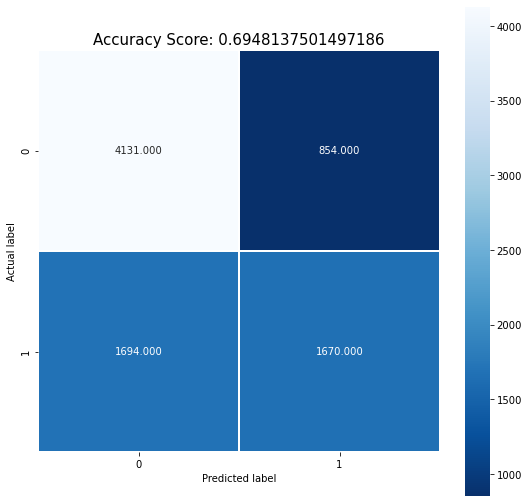

In [112]:
# plots the confusion matrix so it's more visually appealling
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

It looks like this model was OK, but not great. It performed better in predicting customers that would not be retained. On customers that were still active, the model was basically 50/50 in predicting those.

In [114]:
# let's look at the other typical classification scores
prec = metrics.precision_score(y_test, predictions)
rec = metrics.recall_score(y_test, predictions)
print(prec, rec)

0.661648177496038 0.49643281807372175


#### Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model?Include any key indicators of model performance.
I took this approach because the outcome here is booleen: the customer is active or not (True or False; 1 or 0). This lends itself to logistic regression and predicting the probability of retaining a customer. <br>
Since customers are more likely to not be active, the model errs in predicting the users would not be active. This model is a good start, but I believe some better work can be done; the model scored a 69.5% accuracy in predicting the user outcome; 66.2% precision and 49.6% recall. These metrics should the issue in identifying positive outcomes with a lower recall score.

#### Alternatives Model considered
I considered building the model directly using a sigmoid function and then weighting the difference in error. The output would be a percentage, so each part would have a small error. <br>
I also considered different scalars for the model (perhaps a min-max scalar). <br>
I considered taking the log of the number of rides in the first month, as I believe that would probably be exponently distributed (not confirmed). <br>
I considered using other classification methods in modeling; Random Forest would be a good approach, as would Gradient Descent. In using these, its hard to see what's going on under the hood, particularly with Random Forest. <br>
I considered leaving the feature of "left rating" in the model, but then I would not be able to use the average rating of their drivers as a feature. <br>
Given more data, I would almost prefer to model the Customer Lifetime Value based on the first month of ridership. Sure, it's great to retain customers, but it's more important that those customers spend money. We would build a model on customer lifetime value instead of retention. <br>

## 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).
To answer this question, let's look at the coefficients.

In [125]:
coef = logisticRegr.coef_
coef.shape

(1, 11)

In [122]:
X.columns[1]

'avg_rating_of_driver'

In [127]:
coef = logisticRegr.coef_
# let's print out the coefficient with the names of the columns
for n in range(X.shape[1]):
    print(X.columns[n], ": ", coef[0,n])

trips_in_first_30_days :  0.4212080254152723
avg_rating_of_driver :  -0.048731034029269635
avg_surge :  -0.046456794432631544
surge_pct :  0.08023323035558284
ultimate_black_user :  0.47218538038906177
weekday_pct :  0.03890821191347454
avg_dist :  -0.20697288998499902
avg_rating_by_driver :  -0.08286047715940298
city_Astapor :  -0.318204882798414
city_King's Landing :  0.4409997287301552
city_Winterfell :  -0.06209214854897724


## Insights:
Here are some possible ways to improve rider retention: <br>
- Encourage more trips in the first 30-days; the more a user rides in the first 30-days, the more it's integrated into their lifestyle and will be maintained there in 6 months.
- Ultimate Black User: those that use this high-end part of the service were way more likely to be retained. We could be possibly offer options for user to try this service at a discount in their first month (A/B test on this with some users offered this option).
- King's Landing: the users from this town repeat at a higher rate. Perhaps offer more incentives to attract and retain these customers in the first month.